In [1]:
import torch, torchvision
from torch.utils.cpp_extension import CUDA_HOME; 

#check versions and CUDA
print(torch.__version__)
!gcc --version
print(torch.version.cuda)
print(torch.cuda.is_available(), CUDA_HOME)

1.5.0+cu101
gcc (GCC) 8.3.0
Copyright (C) 2018 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

10.1
True /usr/local/cuda


In [6]:
# import common libraries
import numpy as np
import cv2
import os
import random
import matplotlib.pylab as plt

# import some detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm

print(detectron2.__version__)


0.1.2


# Read in data

Input image shape: (2560, 2560, 3)
Minimum pixel value: 0
Maximum pixel value: 255


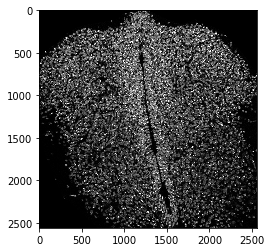

In [3]:
# the image should be divisible by 256 e.g. 1024x1024 or 2084x512


#im = cv2.imread("../full_size_test/T005_350_z1.tif")#,0) # zero for greyscale
#im = cv2.imread("../full_size_test/img_z164.tif")#,0) # zero for greyscale
#im = np.array(PIL.Image.open("./full_size_test/img_z36.tif"))

# andreas SC section E9.5
im = cv2.imread("../full_size_test/andreas/Embryo003_256x2560.tif")#,0) # zero for greyscale


im = 255*((im - np.min(im))/np.ptp(im)) # between 0-255
im = np.uint8(im)

plt.figure()
plt.imshow(im)
INPUT_HEIGHT=np.shape(im)[0]
INPUT_WIDTH=np.shape(im)[1]

print(f'Input image shape: {np.shape(im)}') # check image size
print(f'Minimum pixel value: {np.min(im)}')
print(f'Maximum pixel value: {np.max(im)}')



In [4]:
from Nucleus import ImageTile

one = ImageTile(im, [0,0], 256)

Nucleus


'Couves'

 This image tile has 2560 width and 2560 height. The step is 256.


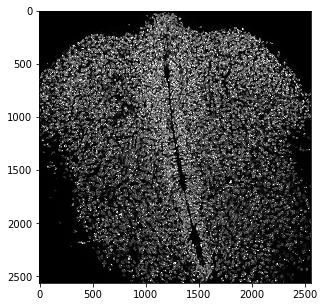

In [5]:
one.show_me()

In [ ]:



step=128
border_step=step

#make MAIN TILES: squares step x step

main_coord =[]
main_tiles = []

for i in range(0,INPUT_HEIGHT,step):
    for j in range(0,INPUT_WIDTH,step):
        print( "Current image is from "+ f'{i} to {i+step} height (y) and {j} to {j+step} width (x).')
        main_tiles.append(im[i:i+step, j:j+step])
        main_coord.append([i,j])
print(np.shape(main_tiles))
print(np.min(main_tiles))
print(np.max(main_tiles))

plt.figure()
plt.imshow(main_tiles[1])


# make vertical stripes to fix nuclei at borders: rectangles step x border_step
v_borders = []
v_coord =[]
for i in range(0,INPUT_HEIGHT,step):
    for j in range(0,INPUT_WIDTH,step):
        if j!=0:
            print( "Current v_border image is from "+ f'{i} to {i+step} height (y) and {j-int(border_step/2)} to {j+int(border_step/2)} width (x).')
            v_borders.append(im[ i:i+step , j-int(border_step/2):j+int(border_step/2)])
            v_coord.append([i,j-int(border_step/2)])

print(np.shape(v_borders))
print(np.min(v_borders))
print(np.max(v_borders))

plt.figure()
plt.imshow(v_borders[0])


# make horizontal stripes to fix nuclei at borders: rectangles border_step x border_step+step 
h_borders = []
h_coord =[]
ys=range(0,INPUT_HEIGHT,step)
xs=range(0,INPUT_WIDTH,step)

for i in ys: # controls y
    if i!=0:
        for j in xs: # controls x
            if j==0:
                print( "Current first h_border image is from "+ f'{i-int(border_step/2)} to {i+int(border_step/2)} height (y) and {j} to {j+step+int(border_step/2)} width (x).')
                h_borders.append(im[ i-int(border_step/2):i+int(border_step/2) , j:j+step+int(border_step/2)])
                h_coord.append([i-int(border_step/2),j])
            elif j==xs[-1]:
                print( "Current last h_border image is from "+ f'{i-int(border_step/2)} to {i+int(border_step/2)} height (y) and {j-int(border_step/2)} to {j+step} width (x).')
                h_borders.append(im[ i-int(border_step/2):i+int(border_step/2) , j-int(border_step/2):j+step])
                h_coord.append([i-int(border_step/2),j-int(border_step/2)])
            else:
                print( "Current h_border image is from "+ f'{i-int(border_step/2)} to {i+int(border_step/2)} height (y) and {j-int(border_step/2)} to {j+step+int(border_step/2)} width (x).')
                h_borders.append(im[ i-int(border_step/2):i+int(border_step/2) , j-int(border_step/2):j+step+int(border_step/2)])
                h_coord.append([i-int(border_step/2),j-int(border_step/2)])


plt.figure()
plt.imshow(h_borders[0])

# Load predictor

In [ ]:
register_coco_instances("nucleus_train", {}, "./nucleus/train_set/train_set.json", "./nucleus/train_set")
register_coco_instances("nucleus_val", {}, "./nucleus/val_set/val_set.json", "./nucleus/val_set/")
register_coco_instances("kromp_train", {}, "./nucleus/krompt2019/images/krompt_TRmodified_nuclei.json", "./nucleus/krompt2019/images/")
register_coco_instances("seg_take2_512", {}, "./nucleus/seg_take2_512/trainval.json", "./nucleus/seg_take2_512")


In [ ]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml"))

cfg.DATASETS.TRAIN = ("nucleus_train","kromp_train")
cfg.OUTPUT_DIR = './output_hyper_best_cascade_mask_rcnn_X_152_bs=256_lr=0.0025/'


cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
#cfg.SOLVER.BASE_LR = lr  # pick a good LR default: 0.00025
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = batch_size   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
# set the testing threshold for this model
cfg.DATASETS.TEST = ("nucleus_train", )
predictor = DefaultPredictor(cfg)


## Test predictor

In [ ]:
### predict MAIN TILES
import timeit
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import GenericMask


tic=timeit.default_timer()
print("Main tiles")
main_instances = []
for i in range(0,len(main_tiles)):
    print(i, end = '..')
    im=main_tiles[i]
    outputs = predictor(im)
    predictions = outputs["instances"].to("cpu")
    main_instances.append(predictions)


print("\n\nVertical stripes")
v_instances = []
for i in range(0,len(v_borders)):
    print(i, end = '..')
    im=v_borders[i]
    outputs = predictor(im)
    predictions = outputs["instances"].to("cpu")
    v_instances.append(predictions)

print("\n\nHorizontal stripes")
h_instances = []
for i in range(0,len(h_borders)):
    print(i, end = '..')
    im=h_borders[i]
    outputs = predictor(im)
    predictions = outputs["instances"].to("cpu")
    h_instances.append(predictions)\

toc=timeit.default_timer()
print(f'\n\nThe time was {toc - tic}')

In [ ]:
im=main_tiles[91]
plt.imshow(im)
np.sum(im>0)
#if np.sum(im>0)>300:
#    outputs = predictor(im)
#    predictions = outputs["instances"].to("cpu")
#    main_instances.append(predictions)

In [ ]:
#check a given individual tile prediction

i=23
im_tile = main_tiles[i]
predictions = main_instances[i]
print(main_coord[i])

#im = v_borders[i]
#predictions = v_instances[i]
#print(v_coord[i])


#im = h_borders[i]
#predictions = h_instances[i]
#print(h_coord[i])

v = Visualizer(im_tile[:, :, ::-1],
               metadata=None,
               scale=1, instance_mode=ColorMode.IMAGE)

boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
scores = predictions.scores if predictions.has("scores") else None
classes = predictions.pred_classes if predictions.has("pred_classes") else None
masks = np.asarray(predictions.pred_masks)
masks = [GenericMask(x, np.shape(x)[0], np.shape(x)[1]) for x in masks] 

#v = v.overlay_instances(boxes = boxes,masks=masks, alpha=0.5)
v = v.overlay_instances(masks=masks, alpha=0.2)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(v.get_image()[:, :, ::-1])

In [ ]:
STITCH_width=5 # the margin from edge to remove and add new nuclei

nuclei_tally = 1
seg_mask = torch.zeros((INPUT_HEIGHT,INPUT_WIDTH))


tic=timeit.default_timer()
# good instances from main tiles

stitch_borders = torch.zeros((INPUT_HEIGHT,INPUT_WIDTH))
for i in range(0,INPUT_HEIGHT,step):
        for j in range(0,INPUT_WIDTH,step):
            stitch_borders[i:i+step, j-STITCH_width:j+STITCH_width]=1
            stitch_borders[i-STITCH_width:i+STITCH_width, j:j+step]=1
        
for i in range(0,len(main_instances)):
    a=main_instances[i].pred_masks
    for nucleus in range(0, len(a)):
        x,y = torch.where(a[nucleus]==1)
        if torch.max(stitch_borders[x+main_coord[i][0] , y + main_coord[i][1]])==0:
            seg_mask[x+main_coord[i][0] , y + main_coord[i][1]] = nuclei_tally
            nuclei_tally += 1


            
            
# add good instances from vertical tiles
stitch_borders_v = torch.zeros((INPUT_HEIGHT,INPUT_WIDTH))
for i in range(0,INPUT_HEIGHT,step):
        for j in range(0,INPUT_WIDTH,step):
            #if i==0:
            stitch_borders_v[i:i+step, j-STITCH_width:j+STITCH_width]=1
            #elif i==range(0,INPUT_HEIGHT,step)[-1]:
            #    stitch_borders[i+STITCH_width:i+step, j-STITCH_width:j+STITCH_width]=1
            #else:
            #    stitch_borders[i+STITCH_width:i+step-STITCH_width, j-STITCH_width:j+STITCH_width]=1

stitch_borders_h = torch.zeros((INPUT_HEIGHT,INPUT_WIDTH))
for i in range(0,INPUT_HEIGHT,step):
    for j in range(0,INPUT_WIDTH,step):
        if i!=0:
            stitch_borders_h[i-STITCH_width:i+STITCH_width, j:j+step]=1


for i in range(0,len(v_instances)):
    a=v_instances[i].pred_masks
    for nucleus in range(0, len(a)):
        x,y = torch.where(a[nucleus]==1)
        cond1=torch.max(stitch_borders_v[x+v_coord[i][0] , y + v_coord[i][1]])==torch.tensor(1) #on the v_border
        cond2=torch.max(stitch_borders_h[x+v_coord[i][0] , y + v_coord[i][1]])==torch.tensor(0) #not on the horizontal
        if cond1 and cond2:
            seg_mask[x+v_coord[i][0] , y + v_coord[i][1]] = nuclei_tally
            nuclei_tally += 1            

            

            
# add good instances from horizontal tiles with attention to corners

for i in range(0,len(h_instances)):
    
    a=h_instances[i].pred_masks
    
    if h_coord[i][1]== 0: # left edge of image case
        stitch_borders_x = torch.zeros((INPUT_HEIGHT,INPUT_WIDTH))
        i_yy=h_coord[i][0]+int(border_step/2)
        stitch_borders_x[i_yy-STITCH_width:i_yy+STITCH_width ,  h_coord[i][1]:h_coord[i][1]+step]=1 # leaves out the +int(border_step/2) 
        #plt.figure(figsize=(5,5))
        #plt.imshow(stitch_borders_x)
        for nucleus in range(0, len(a)):
            x,y = torch.where(a[nucleus]==1)
            cond1=torch.max(stitch_borders_x[x+h_coord[i][0] , y + h_coord[i][1]])==torch.tensor(1) #on the h_border
            #cond2=torch.max(stitch_borders_h[x+v_coord[i][0] , y + v_coord[i][1]])==torch.tensor(0) #not on the horizontal
            if cond1:# and cond2:
                seg_mask[x+h_coord[i][0] , y + h_coord[i][1]] = nuclei_tally
                nuclei_tally += 1

    elif (h_coord[i][1]+step+int(border_step/2))== INPUT_WIDTH: # right edge of image case
        stitch_borders_x = torch.zeros((INPUT_HEIGHT,INPUT_WIDTH))
        i_yy=h_coord[i][0]+int(border_step/2)
        stitch_borders_x[i_yy-STITCH_width:i_yy+STITCH_width ,  h_coord[i][1]+int(border_step/2):h_coord[i][1]+step+int(border_step/2)]=1 # leaves out the int(border_step/2) 
        #plt.figure(figsize=(5,5))
        #plt.imshow(stitch_borders_x)
        for nucleus in range(0, len(a)):
            x,y = torch.where(a[nucleus]==1)
            cond1=torch.max(stitch_borders_x[x+h_coord[i][0] , y + h_coord[i][1]])==torch.tensor(1) 
            if cond1:
                seg_mask[x+h_coord[i][0] , y + h_coord[i][1]] = nuclei_tally
                nuclei_tally += 1
    else: # in the middle images
        stitch_borders_z = torch.zeros((INPUT_HEIGHT,INPUT_WIDTH))
        i_yy=h_coord[i][0]+int(border_step/2)
        stitch_borders_z[i_yy-STITCH_width:i_yy+STITCH_width ,  h_coord[i][1]+int(border_step/2) : h_coord[i][1]+step+int(border_step/2)  ]=1 # leaves out the int(border_step/2) 
        #print((i_yy+STITCH_width)-(i_yy-STITCH_width))
        #print(  (h_coord[i][1]+step+int(border_step/2) )-(h_coord[i][1]+int(border_step/2)) )
        #plt.figure(figsize=(5,5))
        #plt.imshow(stitch_borders_z)
        for nucleus in range(0, len(a)):
            x,y = torch.where(a[nucleus]==1)
            cond1=torch.max(stitch_borders_z[x+h_coord[i][0] , y + h_coord[i][1]])==torch.tensor(1) 
            if cond1:
                seg_mask[x+h_coord[i][0] , y + h_coord[i][1]] = nuclei_tally
                nuclei_tally += 1

toc=timeit.default_timer()
print(f'The time was {toc - tic} sec')
            
                    
plt.figure(figsize=(10,10))
#plt.subplot(1,2,1)
#plt.imshow(stitch_borders_z)
#plt.subplot(1,2,2)
plt.imshow(seg_mask)
#cv2.imwrite('segm_stitch_test.tif', np.asarray(seg_mask))

print(nuclei_tally)

In [ ]:
# detectron2 style plot stitched nuclei
# probably better way to plot these than making many binary copies... polygons?

tic=timeit.default_timer()


# get masks individual nuclei
masks = seg_mask.cpu().numpy()

#masks= seg_mask_no_stitch.cpu().numpy()

indiv_nuc = np.unique(masks)


collect_masks = []
pixel_areas =[]
for i in tqdm(indiv_nuc):
    if i!=0:
        mask_one = np.where(masks!=i, 0, masks)
        mask_one = np.where(mask_one==i, 1, mask_one)
        mask_one = mask_one.astype('bool')
        #pixel_areas.append(np.sum(mask_one))
        nucleus_area=np.sum(mask_one)
        if nucleus_area>300:
            pixel_areas.append(nucleus_area)
            collect_masks.append(GenericMask(mask_one, INPUT_HEIGHT, INPUT_WIDTH))



print( f'The number of nuclei detected in this image is {len(collect_masks)}.' )



plt.figure(figsize=(10,5))
plt.hist(pixel_areas, bins=150)

#masks = np.asarray(collect_masks)
#masks = [GenericMask(x, INPUT_HEIGHT, INPUT_WIDTH) for x in masks]
#masks = collect_masks


toc=timeit.default_timer()
print(f'The time was {toc - tic}')

In [ ]:
# quick check before saving

plt.figure()
plt.imshow(im)

print(len(collect_masks))

In [ ]:
# save figure

tic=timeit.default_timer()


v = Visualizer(im[:, :, ::-1],
               metadata=None,
               scale=1, instance_mode=ColorMode.IMAGE)

v = v.overlay_instances(masks=collect_masks, alpha=0.2)

#plt.figure(figsize=(10,10))
#plt.imshow(v.get_image()[:, :, ::-1])

#pixel_areas

cv2.imwrite('../full_size_test/andreas/Embryo003_256x2560_trial_128.tif', v.get_image()[:, :, ::-1])


toc=timeit.default_timer()
print(f'The time was {toc - tic}')

In [ ]:
# save the visualization
import timeit
tic=timeit.default_timer()


masks = collect_masks

v = Visualizer(im[:, :, ::-1],
               metadata=None,
               scale=1, instance_mode=ColorMode.IMAGE)

v = v.overlay_instances(masks=masks, alpha=0.2)

#plt.figure(figsize=(20,20))
#plt.imshow(v.get_image()[:, :, ::-1])

#pixel_areas

cv2.imwrite('../full_size_test/andreas/Embryo003_256x2560_trial.tif', v.get_image()[:, :, ::-1])


toc=timeit.default_timer()
print(f'The time was {toc - tic}')

In [ ]:
# detectron2 style plot 

# no stitching

#nuclei_tally = 1
#seg_mask_no_stitch = torch.zeros((INPUT_HEIGHT,INPUT_WIDTH))

#for i in range(0,len(main_instances)):
#    a=main_instances[i].pred_masks
#    for nucleus in range(0, len(a)):
#        x,y = torch.where(a[nucleus]==1)
#        seg_mask_no_stitch[x+main_coord[i][0] , y + main_coord[i][1]] = nuclei_tally
#        nuclei_tally += 1



# get masks individual nuclei
masks = seg_mask.cpu().numpy()

#masks= seg_mask_no_stitch.cpu().numpy()

collect_masks = []
pixel_areas =[]
for i in np.unique(masks):
    if i!=0:
        mask_one = np.where(masks!=i, 0, masks)
        mask_one = np.where(mask_one==i, 1, mask_one)
        mask_one = mask_one.astype('bool')
        #pixel_areas.append(np.sum(mask_one))
        nucleus_area=np.sum(mask_one)
        if nucleus_area>300:
            pixel_areas.append(nucleus_area)
            collect_masks.append(GenericMask(mask_one, INPUT_HEIGHT, INPUT_WIDTH))


print( f'The number of nuclei detected in this image is {len(collect_masks)}.' )



plt.figure(figsize=(10,5))
plt.hist(pixel_areas, bins=150)

#masks = np.asarray(collect_masks)
#masks = [GenericMask(x, INPUT_HEIGHT, INPUT_WIDTH) for x in masks]


v = Visualizer(im[:, :, ::-1],
               metadata=None,
               scale=1, instance_mode=ColorMode.IMAGE)

v = v.overlay_instances(masks=masks, alpha=0.2)

#plt.figure(figsize=(20,20))
#plt.imshow(v.get_image()[:, :, ::-1])

#pixel_areas

cv2.imwrite('../full_size_test/andreas/Embryo003_256x2560_trial.tif', v.get_image()[:, :, ::-1])
